In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_csv('A3/train.csv', index_col='ArticleId')
X = df['Text']
df['Category'].replace(['tech', 'entertainment'], [0,1], inplace=True)
Y = df['Category']

df_test = pd.read_csv('A3/test.csv', index_col='ArticleId')
X_test = df_test['Text']
df_test['Category'].replace(['tech', 'entertainment'], [0,1], inplace=True)
Y_test = df_test['Category']


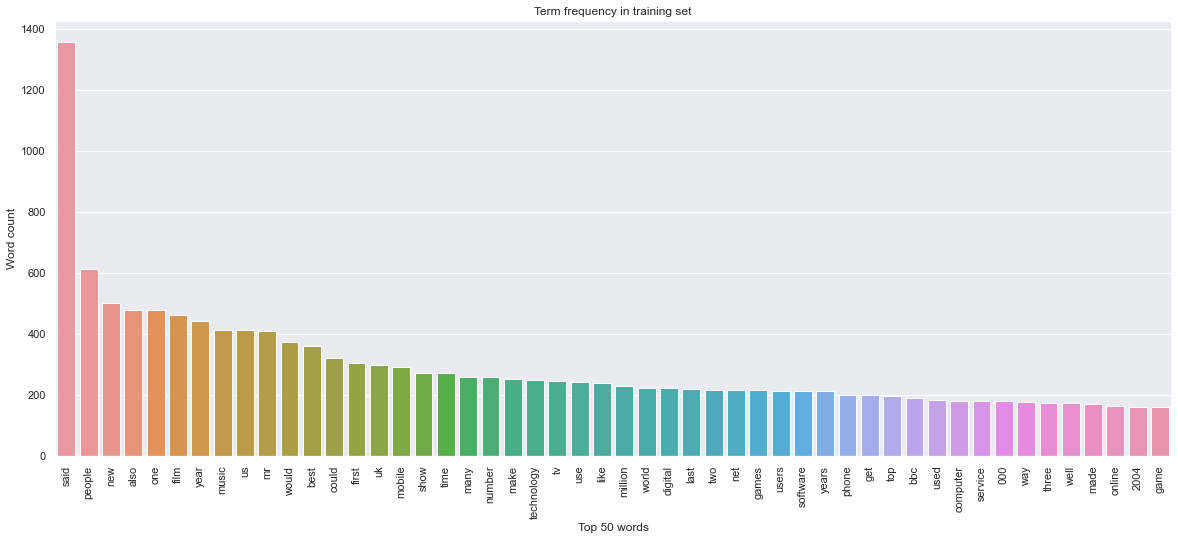

In [2]:
# Frequency count for training set
vectorizer = CountVectorizer()
vectorizer.fit(X)
# Encode document
vector = vectorizer.transform(X)
prep_X_count = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=X.index)
#print(prep_X_count)

# Frequency count for test set
vectorizer_test = CountVectorizer()
vectorizer_test.fit(X_test)
# Encode document
vector_test = vectorizer_test.transform(X_test)
prep_X_test_count = pd.DataFrame(vector_test.toarray(), columns=sorted(vectorizer_test.vocabulary_), index=X_test.index)
#print(prep_X_test_count)

train_sum = prep_X_count.sum().sort_values(ascending=False)
test_sum = prep_X_test_count.sum().sort_values(ascending=False)

train_top_50 = train_sum.head(50)

sns.set(rc = {'figure.figsize':(20,8)})
plot = sns.barplot(x=train_top_50.index, y=train_top_50.values)
plot.set_xlabel('Top 50 words')
plot.set_ylabel('Word count')
plot.set_title('Term frequency in training set')
plt.xticks(rotation = 90)
plt.show()

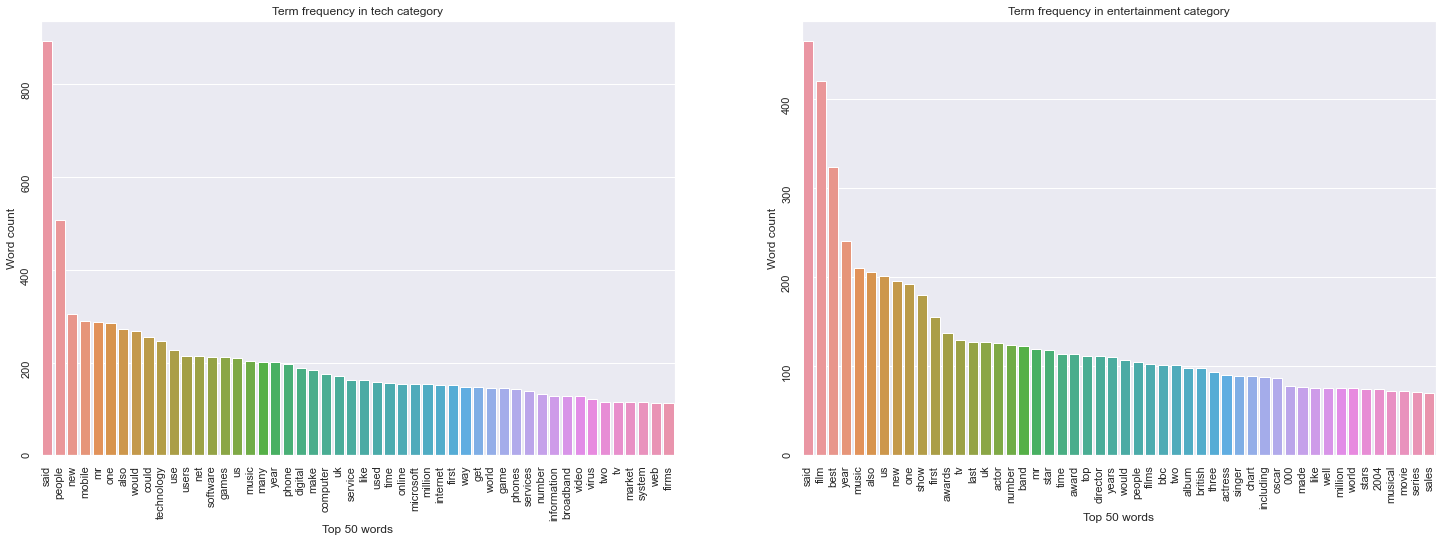

In [3]:
train_label_group = Y.groupby(Y)
train_tech, train_entertain = train_label_group.get_group(0).index, train_label_group.get_group(1).index

train_tech_sum = prep_X_count.loc[train_tech].sum().sort_values(ascending=False)
train_entertain_sum = prep_X_count.loc[train_entertain].sum().sort_values(ascending=False)

train_top_50_tech = train_tech_sum.head(50)
train_top_50_entertain = train_entertain_sum.head(50)

fig, ax = plt.subplots(ncols=2, figsize=(25, 8))
ax[0] = sns.barplot(x=train_top_50_tech.index, y=train_top_50_tech.values, ax=ax[0])
ax[0].set_xlabel('Top 50 words')
ax[0].set_ylabel('Word count')
ax[0].set_title('Term frequency in tech category')
ax[0].tick_params(labelrotation=90)

ax[1] = sns.barplot(x=train_top_50_entertain.index, y=train_top_50_entertain.values, ax=ax[1])
ax[1].set_xlabel('Top 50 words')
ax[1].set_ylabel('Word count')
ax[1].set_title('Term frequency in entertainment category')
ax[1].tick_params(labelrotation=90)
plt.show()

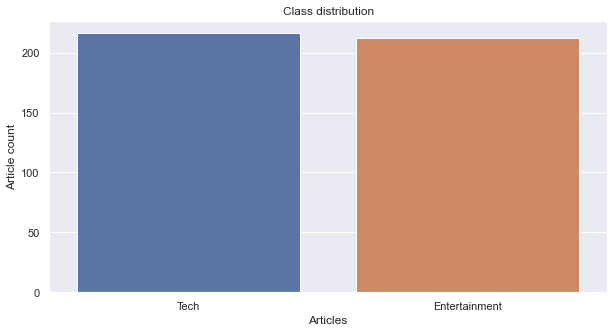

In [4]:
sns.set(rc = {'figure.figsize':(10,5)})
plot = sns.barplot(x=['Tech', 'Entertainment'], y=[train_tech.size, train_entertain.size])
plot.set_xlabel('Articles')
plot.set_ylabel('Article count')
plot.set_title('Class distribution')
plt.show()

In [5]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
# summarize
print(f'vector vocabulary - {vectorizer.vocabulary_}\n')

# encode document
vector = vectorizer.transform(X)
""" print(f'features\n {vectorizer.get_feature_names_out()}\n')
# summarize encoded vector
print(f'vector shape: {vector.shape}\n')
print(f'article vector\n {vector.toarray()}') """

prep_X = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=X.index)
print(prep_X.shape)


vector vocabulary - {'lifestyle': 7222, 'governs': 5566, 'mobile': 7939, 'choice': 2494, 'faster': 4785, 'better': 1620, 'funkier': 5262, 'hardware': 5798, 'alone': 851, 'going': 5526, 'help': 5898, 'phone': 9010, 'firms': 4961, 'sell': 10811, 'handsets': 5771, 'research': 10186, 'suggests': 11791, 'instead': 6485, 'keen': 6877, 'get': 5432, 'customers': 3339, 'pushing': 9665, 'technology': 12090, 'sake': 10573, 'consumers': 3017, 'far': 4769, 'interested': 6528, 'fit': 4969, 'screen': 10721, 'size': 11124, 'onboard': 8515, 'memory': 7751, 'chip': 2491, 'inside': 6460, 'shows': 11024, 'depth': 3615, 'study': 11710, 'handset': 5770, 'maker': 7497, 'ericsson': 4459, 'historically': 5973, 'industry': 6387, 'much': 8075, 'focus': 5047, 'using': 12845, 'said': 10567, 'dr': 4006, 'michael': 7816, 'bjorn': 1684, 'senior': 10831, 'advisor': 701, 'media': 7714, 'consumer': 3016, 'enterprise': 4405, 'lab': 6993, 'stop': 11613, 'saying': 10637, 'technologies': 12089, 'change': 2406, 'lives': 7307

In [6]:
temp_complete_test = pd.concat([X, X_test])

vectorizer = TfidfVectorizer()
vectorizer.fit(temp_complete_test)
# summarize
# print(f'vector vocabulary - {vectorizer.vocabulary_}\n')

# encode document
vector = vectorizer.transform(temp_complete_test)
""" print(f'features\n {vectorizer.get_feature_names_out()}\n')
# summarize encoded vector
print(f'vector shape: {vector.shape}\n')
print(f'article vector\n {vector.toarray()}') """

temp_complete_test_prep = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=temp_complete_test.index)
print(temp_complete_test_prep.head())

prep_X_train = temp_complete_test_prep[:428]
prep_X_test = temp_complete_test_prep[428:]
print(prep_X_test.shape)
print(prep_X_train.shape)

            00       000  000th  001st  0051  007  0100  0130  028  0400  ...  \
ArticleId                                                                 ...   
1976       0.0  0.020253    0.0    0.0   0.0  0.0   0.0   0.0  0.0   0.0  ...   
1797       0.0  0.000000    0.0    0.0   0.0  0.0   0.0   0.0  0.0   0.0  ...   
1866       0.0  0.000000    0.0    0.0   0.0  0.0   0.0   0.0  0.0   0.0  ...   
1153       0.0  0.000000    0.0    0.0   0.0  0.0   0.0   0.0  0.0   0.0  ...   
342        0.0  0.000000    0.0    0.0   0.0  0.0   0.0   0.0  0.0   0.0  ...   

           zombie  zombies  zone  zonealarm  zones  zoom  zooms   zooropa  \
ArticleId                                                                   
1976          0.0      0.0   0.0        0.0    0.0   0.0    0.0  0.000000   
1797          0.0      0.0   0.0        0.0    0.0   0.0    0.0  0.000000   
1866          0.0      0.0   0.0        0.0    0.0   0.0    0.0  0.000000   
1153          0.0      0.0   0.0        0.0    

# Neural Network

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
import warnings

warnings.filterwarnings('ignore')

np.random.seed(1)

init_weigths = np.random.uniform(0., 0.1, 14927)
hid_units = [5,20,40]
results = []

for hid_unit in hid_units:
    clf = MLPClassifier(hidden_layer_sizes=(hid_unit,), solver='sgd', learning_rate_init=0.01, max_iter=100)
    clf.coefs_ = init_weigths

    clf.fit(prep_X_train,Y)

    preds = clf.predict(prep_X_test)
    score = clf.score(prep_X_test, Y_test)

    loss = log_loss(Y_test, preds)
    results.append([hid_unit, loss, score])

print(results)

[[5, 0.3258450565315187, 0.9905660377358491], [20, 9.992007221626413e-16, 1.0], [40, 0.6516825696910535, 0.9811320754716981]]


[]

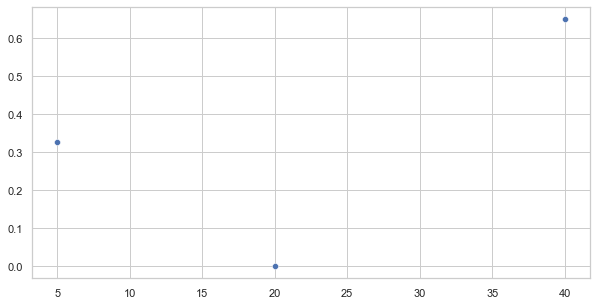

In [8]:
sns.set_style('whitegrid')
results = np.array(results).T
plot = sns.scatterplot(x=results[0], y=results[1])
plt.plot()